In [94]:
import torch 
torch.cuda.is_available()

True

In [95]:
torch.cuda.current_device()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2060'

### Heater ML Model

In [71]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd 
from nltk.corpus import stopwords 
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import math 
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
import numpy as np 
import statistics 
from sklearn.feature_extraction.text import CountVectorizer 
from textblob import TextBlob
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
import os 
import pandas as pd
from transformers import pipeline
import torch
import time
from datetime import timedelta
import psutil
import ray
import re

from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Clarence\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Clarence\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [72]:
data_folder = "heater_data"
# data_filename = "product_review_heater4.csv"
data_filenames = os.listdir(data_folder)
dfs = []

for data_filename in data_filenames: 
    data_filepath = os.path.join(data_folder, data_filename)
    df = pd.read_csv(data_filepath)
    df = df.replace(r'^\s*$', np.nan, regex=True)
    dfs.append(df)
    
df_uncleaned = pd.concat(dfs)
df_uncleaned = df_uncleaned.drop_duplicates(subset=['Title'], keep='last')
df_uncleaned.shape

(5562, 1222)

In [73]:
# data_folder = "data" 
# data_filename = "heater1.csv"


# df_uncleaned = pd.read_csv(os.path.join(data_folder, data_filename))

In [74]:
print(df_uncleaned.columns)
df_uncleaned.info()

Index(['Title', 'Price', 'Sold', 'Reviews', 'Condition', 'Model', 'Type 1',
       'Material', 'Type', 'MPN',
       ...
       'Air Volume (CFM)', 'Installation Type', 'Light Bulb Base Code',
       'Construction', 'BTU Output', 'Part/Accessory Type', 'Hanger Type',
       'Number of Bars', 'Fit', 'Second eBay Category'],
      dtype='object', length=1222)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5562 entries, 1 to 302
Columns: 1222 entries, Title to Second eBay Category
dtypes: float64(143), object(1079)
memory usage: 51.9+ MB


In [75]:
for column in df_uncleaned.columns: 
    print(column)

Title
Price
Sold
Reviews
Condition
Model
Type 1
Material
Type
MPN
Brand
Voltage
Size
Color
Mounting Location
UPC
Marke
Annual Fuel Utilization Efficiency (AFUE)
Gas Consumption (kg/h)
Gas Type
Ignition Device
Overheat Cut-Off Temperature
Supply Pressure (Mbar)
EAN
Power Source
Item Length
Colour
Heating Element Material
Control Style
Heating System
Item Width
Power
Manufacturer Part Number
Manufacturer
Item Height
Item Weight
Number of Heat Settings
Smart Home Compatibility
Area Covered
Features
Smart Home Protocol
Operating Sound Rating
Heating Element Format
BTU Heating Rating
Energy Efficiency Ratio (EER)
Item Depth
Tank Capacity
Power/Fuel Type
Indoor/Outdoor
Product Weight (lb)
Amperage (amps)
Room Size
Product Width (in)
Portable Heater Features
Cord Length (in)
Area Heated (Sq Ft)
Wattage (watts)
Heater Type
Certifications and Listings
Product Height (in)
Color Family
Portable Heater Safety Features
Heater Controls
Voltage (volts)
Product Depth (in)
Year Manufactured
Air Directi

Amperage amps
Anti-freeze Setting
Acli Safety Plug
Certifications And Listings
Heat Rating (btu/hour)
Automatic Shutoff
Area Heated (sq. Ft.)
Indoor/outdoor
Room Size (sq. Ft.)
Isbn
Package size
Product Length (in.)
weight
Sport/Activity
LOCATION
globalTradeItemNumber (GTIN)
Number of Elements
Delivery
Overall
Watt
Items Included
Shape
Cooking Area Width
Cooking Area Length
Item Diameter
Scent
Product Weight
Release Date
Includes
Start Type
Mounting Type
Overall Depth
CFM
Collection
Number of Bulbs
UL Listed
Laser 73
Laser 73 Parts
Voltage volts
Product Width in
BTU Heating
Heating Element Type:
Amperage:
Application:
Type:
Plug Type:
Unit of measure
Fabric Type
Output
ECO mode temp
In Sku
Overall Dimension
Maximum Energy Power
Net Weight
Power Cord Length
Power/fuel Type
Maximum Air Flow
Setting(btu)
Certifications
Air output
Heat coverage
Fuel consumption
Net weight
Protection
Package includes
Pressure
Item weight
Main Colour
Power Output
Service
USA Shipping
UNSPSC Code
Installation

In [76]:
df = df_uncleaned.copy()
non_numeric_cols = pd.Index(set(df.columns).difference(set(df.select_dtypes(include=(np.number)).columns)))
# for col in non_numeric_cols: 
#     df[col] = df[col].apply(lambda val: str(val).lower())
columns_to_drop = ['Title', "Brand", "Year Manufactured", 'Sold', 'Reviews', 'Condition', 'Model', 'UPC', 'MPN', 'ISBN', 'EAN', 'Size', 'Manufacturer Part Number', "Manufacturer", "Smart Home Compatibility"]
df.columns = map(lambda col: col.strip(), df.columns)
df = df.drop(columns_to_drop, axis=1)
df.dropna(axis=1, how='any', thresh=40, inplace=True)
# df.dropna(axis=1, how='any', thresh=0.1*df.shape[0], inplace=True)
# df = df[df.columns[df.nunique() > 1]]
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5562 entries, 1 to 302
Data columns (total 98 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Price                                      5053 non-null   object 
 1   Material                                   2789 non-null   object 
 2   Type                                       4096 non-null   object 
 3   Voltage                                    2609 non-null   object 
 4   Color                                      3763 non-null   object 
 5   Mounting Location                          2476 non-null   object 
 6   Annual Fuel Utilization Efficiency (AFUE)  649 non-null    object 
 7   Power Source                               3708 non-null   object 
 8   Item Length                                1167 non-null   object 
 9   Colour                                     137 non-null    object 
 10  Heating Element Material 

In [77]:
#name keys different from value names

cols_to_combine = {
    "colour": ["Color", "Colour", "Color Family"],
    "height": ["Product Height (in)", "Depth","Product Depth (in)","Item Depth","Item Height", "Height", "Product Height (in.)", "ItemHeight", "Height (In.)", "product_height_in", "Product Height"],
    "power source": ["Power Source", "Power/Fuel Type", "Power Type"], 
    "power": ["Power", "Wattage (watts)", "Power (W)", "Heating Wattage"],
    "voltage": ["Voltage", "Voltage (volts)"], 
    "width": ["Item Width", "Product Width (in)", "Width"], 
    "length": ["Item Length", "Length"],
    "heating system": ["Type","Heater Style", "Heating System", "Heating Product Type", "Heating Method", "Heating Technology Type"],
    "control": ["Heater Controls", "Control Style"]
}

In [78]:
for key in cols_to_combine.keys(): 
    cols = cols_to_combine[key]
    df[key] = df_uncleaned[cols[0]]
    for col in cols_to_combine[key]: 
        df[key] = df[key].combine_first(df_uncleaned[col])
        df.drop(col, axis=1, inplace=True, errors='ignore')

In [79]:
df.to_csv("heater_ml_data.csv")

In [80]:
# df["Power Type"].unique()

In [81]:
df.groupby("Heating Element Material").agg("count")

,Price,Material,Mounting Location,Annual Fuel Utilization Efficiency (AFUE),Item Weight,Number of Heat Settings,Area Covered,Features,Smart Home Protocol,Operating Sound Rating,...,Application,colour,height,power source,power,voltage,width,length,heating system,control
Heating Element Material,,,,,,,,,,,,,,,,,,,,,
--,2,2,2,2,0,2,2,2,0,1,...,0,2,1,2,2,2,1,1,2,2
.,2,2,2,1,0,2,2,2,0,2,...,0,2,2,2,2,2,2,2,2,2
..,1,1,1,1,0,1,1,1,0,1,...,0,1,1,1,1,1,1,1,1,1
0,0,1,1,1,0,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
Acrylonitrile Butadiene Styrene (ABS),1,1,1,0,0,1,1,1,0,1,...,0,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
not sure,1,1,1,0,0,1,0,0,0,0,...,0,1,0,1,0,1,0,0,1,1
quartz,3,2,3,0,0,3,1,3,1,2,...,0,2,3,3,3,3,3,3,3,2
read package,1,1,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,1,0,1,0


In [82]:
def lowercase(row): 
    for col in df.columns: 
        if type(row[col]) == str: 
            row[col] = row[col].lower() 
    return row

In [83]:
df = df.apply(lowercase, axis=1)
# unique_cols = df['Heating Element Material'].unique()

# for i in unique_cols: 
#     if type(i) == str:
#         print(i, df.groupby('Heating Element Material').get_group(i).agg('count')['Price'])

In [84]:
cols_to_simplify = {
    "Heating Element Material": 
     [
        {
         "to_replace": "ceramic",
         "search_terms": ["ceramic", "ceremic"], 
        },
        {
         "to_replace": "carbon",
         "search_terms": ["carbon"], 
        },
        {
         "to_replace": "metal",
         "search_terms": ["aluminium", "steel", "brass", "metal", "alluminium", "aluminum", "copper", "iron"], 
        },
        {
         "to_replace": "quartz",
         "search_terms": ["quartz"], 
        },
        {
         "to_replace": "plastic",
         "search_terms": ["plastic", "abs"], 
        },
     ], 
    "heating system": 
     [
        {
         "to_replace": "ceramic heater",
         "search_terms": ["ceramic", "ceremic", "ceramic heater"], 
        },
        {
         "to_replace": "forced air",
         "search_terms": ["forced", "forced air", "fan"], 
        },
        {
         "to_replace": "portable heater",
         "search_terms": ["portable", "portable heater"], 
        },
        
        {
         "to_replace": "convection heater",
         "search_terms": ["convection", "convector", "convection heater"], 
        },
        {
         "to_replace": "oil filled radiator",
         "search_terms": ["oil", "kerosene", "wick", "oil filled radiator"], 
        },
        {
         "to_replace": "infrared heater",
         "search_terms": ["infrared", "infrared heater"], 
        },
        {
         "to_replace": "oscillating heater",
         "search_terms": ["oscillating", "oscillation", "oscillating heater"], 
        },
        {
         "to_replace": "baseboard heater",
         "search_terms": ["baseboard", "baseboard heater"], 
        },

     ],
     "Material": 
     [
        {
         "to_replace": "aluminium",
         "search_terms": ["aluminum", "aluminium"], 
        },
        {
         "to_replace": "steel",
         "search_terms": ["steel"], 
        },
        {
         "to_replace": "ceramic",
         "search_terms": ["ceramic"], 
        },
        
        {
         "to_replace": "wood",
         "search_terms": ["wood"], 
        },
        {
         "to_replace": "plastic",
         "search_terms": ["plastic", "abs"], 
        },
        {
         "to_replace": "brass",
         "search_terms": ["brass"], 
        },
     ],
}

In [85]:
df["Material"].unique()

array([nan,
       'aluminum,nickel,chrome,metal, aluminum, satin finish, chrome, aluminum,metal,chrome, nickel, aluminum,chrome,metal,nickel, metal, satin nickel',
       'ceramic', 'plastic', 'steel', 'metal',
       'metal,ceramic, ceramic,metal, ceramic, metal', 'metal, steel',
       'wood', 'metal, plastic', 'ceramic, steel',
       'ceramic, plastic, metal', 'electronic components', 'brass',
       'metal,steel', 'plastic, metal', 'plasic', 'pvc', 'not specified',
       'aluminum', 'wood, steel', 'aluminium, andere metalle',
       'silicone rubber', 'galvanized steel / copper / aluminum',
       'bakelite', 'metal/steel, metal, steel', 'aluminum, steel',
       'steel, pa', 'heat resistant plastic', 'chrome, steel',
       'aluminum, brass', 'durable', 'does not apply',
       'oil filled - electric - 1.50 kw - 3 x heat settings - white',
       'steel, aluminum', 'seamless stainless steel',
       'nickel plated steel', 'varies', 'steel, pvc',
       'nickel chromium alloy', 

In [86]:
def simplify_class(text, search_terms, to_replace):
    if to_replace == "others": 
        for search_term in search_terms: 
            if type(text) == str: 
                if text in search_terms:
                    return text
                else: 
                    return "others"
        return "others"
    for search_term in search_terms: 
        if type(text) == str: 
            if search_term in text: 
                return to_replace
    return text
    
    

In [87]:
for col in cols_to_simplify.keys(): 
    vals = cols_to_simplify[col]
    all_search = []
    for val in vals: 
        to_replace = val["to_replace"]
        search_terms = val["search_terms"]
        all_search += search_terms
        df[col] = df[col].apply(lambda text: simplify_class(text, search_terms, to_replace))
    df[col] = df[col].apply(lambda text: simplify_class(text, all_search, "others"))

In [88]:
df["heating system"].unique()

array(['others', 'portable heater', 'infrared heater', 'baseboard heater',
       'forced air', 'convection heater', 'oscillating heater',
       'ceramic heater', 'oil filled radiator'], dtype=object)

In [89]:
df.groupby("Material").agg('count')

,Price,Mounting Location,Annual Fuel Utilization Efficiency (AFUE),Heating Element Material,Item Weight,Number of Heat Settings,Area Covered,Features,Smart Home Protocol,Operating Sound Rating,...,Application,colour,height,power source,power,voltage,width,length,heating system,control
Material,,,,,,,,,,,,,,,,,,,,,
aluminium,244,232,111,288,8,226,167,177,94,162,...,8,263,97,266,190,243,156,114,288,225
brass,38,13,5,40,8,23,4,9,20,13,...,0,33,15,32,3,15,17,13,40,12
ceramic,719,537,167,813,12,586,330,542,162,275,...,8,699,231,726,499,570,338,241,813,635
others,2987,828,141,3242,117,705,309,647,136,235,...,22,1832,418,1736,640,936,616,432,3242,710
plastic,311,250,64,368,28,245,161,240,75,115,...,2,317,150,294,271,284,229,132,368,261
steel,717,581,155,770,35,642,302,410,173,236,...,6,710,301,716,392,596,411,259,770,572
wood,37,35,6,41,1,33,16,30,20,18,...,0,39,13,40,34,33,27,10,41,36


In [90]:
df_temp = df

# print(df_uncleaned['Energy Star'].unique())

good_ratings = map(str.lower,["5 Stars", "10 Stars", "C", "Compliant", "A+++", "A++","A+", "A", "Multiple Energy Star", "4.5 Stars", "4 Stars"])

df_temp[df_temp['Energy Star'].isin(good_ratings)].groupby(["heating system"]).agg("count")

,Price,Material,Mounting Location,Annual Fuel Utilization Efficiency (AFUE),Heating Element Material,Item Weight,Number of Heat Settings,Area Covered,Features,Smart Home Protocol,...,Package Contents,Application,colour,height,power source,power,voltage,width,length,control
heating system,,,,,,,,,,,,,,,,,,,,,
baseboard heater,10,11,11,6,11,0,10,7,7,1,...,0,0,10,6,11,10,10,7,6,9
ceramic heater,3,3,3,0,3,0,3,2,3,1,...,0,0,3,2,3,3,3,3,2,3
convection heater,2,5,4,3,5,0,5,5,4,3,...,0,0,5,5,5,5,5,5,3,4
forced air,11,12,12,6,12,0,11,10,12,2,...,0,1,12,6,12,12,11,7,5,11
infrared heater,5,6,6,1,6,0,4,2,4,1,...,0,0,6,4,6,4,5,4,2,6
others,89,150,135,104,150,1,128,118,125,38,...,0,14,133,102,140,129,131,113,105,135
portable heater,189,212,206,133,212,2,187,174,180,47,...,0,6,183,139,212,195,203,156,130,198


In [91]:
df.dropna(axis=1, how='any', thresh=100, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5562 entries, 1 to 302
Data columns (total 39 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Price                                      5053 non-null   object
 1   Material                                   5562 non-null   object
 2   Mounting Location                          2476 non-null   object
 3   Annual Fuel Utilization Efficiency (AFUE)  649 non-null    object
 4   Heating Element Material                   5562 non-null   object
 5   Item Weight                                209 non-null    object
 6   Number of Heat Settings                    2460 non-null   object
 7   Area Covered                               1289 non-null   object
 8   Features                                   2055 non-null   object
 9   Smart Home Protocol                        680 non-null    object
 10  Operating Sound Rating               

In [92]:
import pandas as pd
import re

data = df.copy()

def extract_inches(s): 
    try:
        if 'mm' in s.lower():
            x = float(re.findall(r"[-+]?\d*\.\d+|\d+", s)[0]) * 0.0393701
        elif 'cm' in s.lower():
            x = float(re.findall(r"[-+]?\d*\.\d+|\d+", s)[0]) * 0.393701
        else:
            x = float(re.findall(r"[-+]?\d*\.\d+|\d+", s)[0]) 
        
    except:
        x = 0
    return x
    
    
#     print(x)
df['width'] = data['width'].apply(extract_inches)
df['height'] = data['height'].apply(extract_inches)
df['length'] = data['length'].apply(extract_inches)

In [93]:
print("Median width in inches: ", df[df['width'] != 0]['width'].agg('median'))
print("Median height in inches: ", df[df['height'] != 0]['height'].agg('median'))
print("Median length in inches: ", df[df['length'] != 0]['length'].agg('median'))

Median width in inches:  9.448824
Median height in inches:  9.16
Median length in inches:  12.0


#### Price average

In [94]:
df_temp = df

# print(df_uncleaned['Energy Star'].unique())

good_ratings = list(map(str.lower,["5 Stars", "10 Stars", "C", "Compliant", "A+++", "A++","A+", "A", "Multiple Energy Star", "4.5 Stars", "4 Stars"]))

ave_energy_star_price = df_temp[df_temp['Energy Star'].isin(good_ratings)]["Price"].astype(float).dropna().agg('mean')
ave_no_energy_star_price = df_temp[~df_temp['Energy Star'].isin(good_ratings)]["Price"].astype(float).dropna().agg('mean')

print("Average price for energy star is ", ave_energy_star_price)
print("Average price for non energy star is ", ave_no_energy_star_price)

Average price for energy star is  77.52394822006472
Average price for non energy star is  82.5997681281619


In [95]:
df_temp['Energy Star'].unique()

array([nan, 'not compliant', 'compliant', 'a+', 'a++', 'does not apply',
       'a', '4 stars', 'a+++', 'multiple energy star', '1 star', 'e',
       '5 stars', 'unsure', 'complaint', '3 stars', 'see description',
       'not applicable', 'c', '2 stars', 'null', '10 stars', 'no', 'd',
       "['compliant' 'not compliant']", 'g', '0', 'unknown', '4.5 stars'],
      dtype=object)

In [96]:
df_uncleaned.groupby('Material').get_group('Ceramic')

,Title,Price,Sold,Reviews,Condition,Model,Type 1,Material,Type,MPN,...,Air Volume (CFM),Installation Type,Light Bulb Base Code,Construction,BTU Output,Part/Accessory Type,Hanger Type,Number of Bars,Fit,Second eBay Category
11,Ultra Electric Ceramic Fireplace Portable Spa...,NaN,NaN,NaN,"New: A brand-new, unused, unopened, undamaged ...",NaN,NaN,Ceramic,Portable Heater,CA20100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,Lasko 5572 Room Heater - Ceramic - Electric - ...,NaN,30-day returns,['I purchased the Lasko 5397 oscillating heate...,"New: A brand-new, unused, unopened, undamaged ...",NaN,NaN,Ceramic,Tower Heater,5572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,Lasko Products 5572 Ceramic Tower Heater,104.99,30-day returns,['I purchased the Lasko 5397 oscillating heate...,"New: A brand-new, unused, unopened, undamaged ...",NaN,NaN,Ceramic,Tower Heater,5572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,Portable High End Space Heater w/ Remote Home ...,102.99,NaN,NaN,"New: A brand-new, unused, unopened, undamaged ...",NaN,NaN,Ceramic,Portable Heater,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156,NEW Lasko CA20100 Ultra Ceramic Fireplace Heat...,100.98,NaN,NaN,"New: A brand-new, unused, unopened, undamaged ...",CA20100,NaN,Ceramic,Electric Fireplace,CA20100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,Tower 1500-Watt Electric Portable Ceramic Osci...,98.99,NaN,['I purchased the Lasko 5397 oscillating heate...,"New: A brand-new, unused, unopened, undamaged ...",5572,NaN,Ceramic,Tower Heater,5572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
282,Home Room Kitchen Office Digital Ceramic Tower...,95.0,30-day returns,['Very nice heater! It oscillates back and fo...,"New: A brand-new, unused, unopened, undamaged ...",NaN,NaN,Ceramic,Tower Heater,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286,Home Office Room Safety Digital Ceramic Oscill...,100.0,30-day returns,NaN,"New: A brand-new, unused, unopened, undamaged ...",NaN,NaN,Ceramic,Tower Heater,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295,Heater For Home Foot Warmer Home Heaters Fan H...,98.54,30-day returns,NaN,"New: A brand-new, unused, unopened, undamaged ...",NaN,NaN,Ceramic,Portable Heater,Dose Not Apply,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
# df_uncleaned[]

In [98]:
df_uncleaned.columns

Index(['Title', 'Price', 'Sold', 'Reviews', 'Condition', 'Model', 'Type 1',
       'Material', 'Type', 'MPN',
       ...
       'Air Volume (CFM)', 'Installation Type', 'Light Bulb Base Code',
       'Construction', 'BTU Output', 'Part/Accessory Type', 'Hanger Type',
       'Number of Bars', 'Fit', 'Second eBay Category'],
      dtype='object', length=1222)

In [99]:
cols = ["width", "height", "length", "Heating Element Material", "heating system", "Material"]

In [100]:
df_col = df[cols + ["Energy Star"]]

In [101]:
df_col['Energy Star'].unique()
list(good_ratings)

['5 stars',
 '10 stars',
 'c',
 'compliant',
 'a+++',
 'a++',
 'a+',
 'a',
 'multiple energy star',
 '4.5 stars',
 '4 stars']

In [102]:
# df_col["Energy Star"] = df_col["Energy Star"].fillna(False)
df_col['Energy Star'] = df_col['Energy Star'].isin(good_ratings)
# df_col[df_col["Energy Star"] != False]["Energy Star"] = True

C:\Users\Clarence\AppData\Local\Temp/ipykernel_43296/1355714983.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_col['Energy Star'] = df_col['Energy Star'].isin(good_ratings)


In [103]:
df_col["Energy Star"].unique()

array([False,  True])

In [104]:
from sklearn import preprocessing
df_ml = df_col.copy()
le = preprocessing.LabelEncoder()
# df_ml = pd.get_dummies(df_ml)
# df_ml["Heating Element Material"] = le.fit_transform(df_col["Heating Element Material"])
# df_ml["heating system"] = le.fit_transform(df_col["heating system"])
# df_ml["Material"] = le.fit_transform(df_col["Material"])

In [105]:
df_ml

,width,height,length,Heating Element Material,heating system,Material,Energy Star
1,0.000000,0.00,0.000000,others,others,others,False
3,8.464571,0.00,15.354339,metal,portable heater,others,False
5,0.000000,0.00,0.000000,others,others,others,False
7,11.000000,0.00,0.000000,others,others,aluminium,False
8,0.000000,0.00,0.000000,others,others,others,False
...,...,...,...,...,...,...,...
298,9.000000,14.25,14.250000,metal,others,others,False
299,0.000000,0.00,0.000000,others,others,others,False
300,0.000000,11.00,0.000000,metal,others,aluminium,False
301,13.000000,43.00,13.000000,others,forced air,ceramic,False


In [106]:
df_ml["Energy Star"].unique()

array([False,  True])

In [107]:
df_ml

,width,height,length,Heating Element Material,heating system,Material,Energy Star
1,0.000000,0.00,0.000000,others,others,others,False
3,8.464571,0.00,15.354339,metal,portable heater,others,False
5,0.000000,0.00,0.000000,others,others,others,False
7,11.000000,0.00,0.000000,others,others,aluminium,False
8,0.000000,0.00,0.000000,others,others,others,False
...,...,...,...,...,...,...,...
298,9.000000,14.25,14.250000,metal,others,others,False
299,0.000000,0.00,0.000000,others,others,others,False
300,0.000000,11.00,0.000000,metal,others,aluminium,False
301,13.000000,43.00,13.000000,others,forced air,ceramic,False


In [108]:
# df_ml = pd.get_dummies(df_col, columns = cols_to_simplify.keys())

# X = df_ml
# ms = MeanShift(bin_seeding=True)
# ms.fit(X)
# labels = ms.labels_
# cluster_centers = ms.cluster_centers_
# print(cluster_centers)
# n_clusters_ = len(np.unique(labels))
# print("Estimated clusters:", n_clusters_)
# colors = 10*['r.','g.','b.','c.','k.','y.','m.']
# for i in range(len(X)):
#     plt.plot(X[i][0], X[i][1], colors[labels[i]], markersize = 3)
# plt.scatter(cluster_centers[:,0],cluster_centers[:,1],
#     marker=".",color='k', s=20, linewidths = 5, zorder=10)
# plt.show()

In [109]:
# import math

# def closest_clusters(row, cluster_centers): 
#     max_idx = 0
#     min_dist = float("inf")
#     for i, cluster in enumerate(cluster_centers): 
#         dist = math.sqrt(sum(map(lambda x: x**2, row - cluster)))
#         if dist < min_dist: 
#             min_dist = dist 
#             idx = i
#     return idx

# df_classified = df.apply(lambda row: closest_clusters(row, cluster_centers), axis=1) 

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns

In [111]:
df_col

,width,height,length,Heating Element Material,heating system,Material,Energy Star
1,0.000000,0.00,0.000000,others,others,others,False
3,8.464571,0.00,15.354339,metal,portable heater,others,False
5,0.000000,0.00,0.000000,others,others,others,False
7,11.000000,0.00,0.000000,others,others,aluminium,False
8,0.000000,0.00,0.000000,others,others,others,False
...,...,...,...,...,...,...,...
298,9.000000,14.25,14.250000,metal,others,others,False
299,0.000000,0.00,0.000000,others,others,others,False
300,0.000000,11.00,0.000000,metal,others,aluminium,False
301,13.000000,43.00,13.000000,others,forced air,ceramic,False


In [112]:
df_ml[df_ml['Energy Star'] == True] 

,width,height,length,Heating Element Material,heating system,Material,Energy Star
40,14.000000,4.0,13.000000,others,infrared heater,plastic,True
145,7.086618,16.0,17.716545,metal,convection heater,others,True
146,11.420000,13.5,15.750000,quartz,portable heater,others,True
179,0.000000,0.0,0.000000,others,portable heater,others,True
228,11.000000,9.0,12.000000,others,portable heater,plastic,True
...,...,...,...,...,...,...,...
183,7.086618,16.0,17.716545,metal,convection heater,others,True
185,0.000000,0.0,0.000000,metal,others,steel,True
234,0.000000,0.0,0.000000,others,others,steel,True
256,5.511814,11.0,10.629927,metal,others,steel,True


In [113]:
# df_ml = df_ml[df_ml["width"] != 0]
# df_ml = df_ml[df_ml["length"] != 0]
# df_ml = df_ml[df_ml["height"] != 0]
df_ml

,width,height,length,Heating Element Material,heating system,Material,Energy Star
1,0.000000,0.00,0.000000,others,others,others,False
3,8.464571,0.00,15.354339,metal,portable heater,others,False
5,0.000000,0.00,0.000000,others,others,others,False
7,11.000000,0.00,0.000000,others,others,aluminium,False
8,0.000000,0.00,0.000000,others,others,others,False
...,...,...,...,...,...,...,...
298,9.000000,14.25,14.250000,metal,others,others,False
299,0.000000,0.00,0.000000,others,others,others,False
300,0.000000,11.00,0.000000,metal,others,aluminium,False
301,13.000000,43.00,13.000000,others,forced air,ceramic,False


In [114]:
df_ml = pd.get_dummies(df_ml)
df_ml.columns

Index(['width', 'height', 'length', 'Energy Star',
       'Heating Element Material_carbon', 'Heating Element Material_ceramic',
       'Heating Element Material_metal', 'Heating Element Material_others',
       'Heating Element Material_plastic', 'Heating Element Material_quartz',
       'heating system_baseboard heater', 'heating system_ceramic heater',
       'heating system_convection heater', 'heating system_forced air',
       'heating system_infrared heater', 'heating system_oil filled radiator',
       'heating system_oscillating heater', 'heating system_others',
       'heating system_portable heater', 'Material_aluminium',
       'Material_brass', 'Material_ceramic', 'Material_others',
       'Material_plastic', 'Material_steel', 'Material_wood'],
      dtype='object')

In [115]:
from sklearn.model_selection import train_test_split 



X_train, y_train, X_test, y_test = train_test_split(df_ml.drop('Energy Star', 1), df_ml['Energy Star'], test_size=0.2)

# X = df_ml.drop('Energy Star', 1)
# y = df_ml['Energy Star']

def train_test_split(df, frac=0.2):
    
    # get random sample 
    test = df.sample(frac=frac, axis=0)

    # get everything but the test sample
    train = df.drop(index=test.index)

    return train, test

train_df, test_df = train_test_split(df_ml)

X_train, y_train = train_df.drop('Energy Star', 1), train_df['Energy Star']
X_test, y_test = test_df.drop('Energy Star', 1), test_df['Energy Star']
# percentage_data = 0.8

# X_train = X.iloc[:round(percentage_data*X.shape[0])]
# y_train = y.iloc[:round(percentage_data*y.shape[0])]
# X_test = X.iloc[round(percentage_data*X.shape[0]):]
# y_test = y.iloc[round(percentage_data*y.shape[0]):]

# sm = SMOTE(random_state=42)
# x_res, y_res = sm.fit_resample(X_train, y_train)

clf = LogisticRegression(random_state=0, class_weight='balanced').fit(X_train, y_train)

clf.get_params()

C:\Users\Clarence\AppData\Local\Temp/ipykernel_43296/2565199634.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train, y_train, X_test, y_test = train_test_split(df_ml.drop('Energy Star', 1), df_ml['Energy Star'], test_size=0.2)
C:\Users\Clarence\AppData\Local\Temp/ipykernel_43296/2565199634.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train, y_train = train_df.drop('Energy Star', 1), train_df['Energy Star']
C:\Users\Clarence\AppData\Local\Temp/ipykernel_43296/2565199634.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test, y_test = test_df.drop('Energy Star', 1), test_df['Energy Star']
C:\Users\Clarence\Documents\School\1. DAI\AI_code\ai_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: Converge

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [116]:
clf.score(X_test,y_test)

0.7850719424460432

In [117]:
y_pred = clf.predict(X_test)

In [118]:
cf_matrix = confusion_matrix(y_test, y_pred)

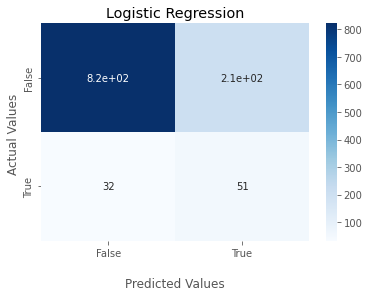

Accuracy score:  0.7850719424460432
Precision score:  0.19767441860465115
Recall score:  0.6144578313253012


In [119]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Logistic Regression');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Precision score: ", precision_score(y_test, y_pred))
print("Recall score: ", recall_score(y_test, y_pred))

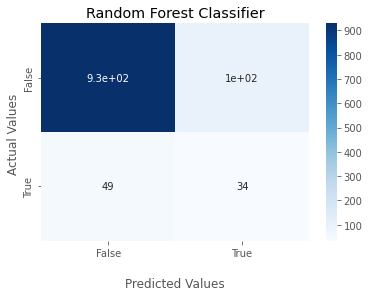

Accuracy score:  0.8660071942446043
Precision score:  0.2537313432835821
Recall score:  0.40963855421686746


In [120]:
from sklearn.ensemble import RandomForestClassifier
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(X_train, y_train)
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(x_res, y_res)

clf.score(X_test,y_test)
y_pred = clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Random Forest Classifier');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Precision score: ", precision_score(y_test, y_pred))
print("Recall score: ", recall_score(y_test, y_pred))

In [121]:
df_ml

,width,height,length,Energy Star,Heating Element Material_carbon,Heating Element Material_ceramic,Heating Element Material_metal,Heating Element Material_others,Heating Element Material_plastic,Heating Element Material_quartz,...,heating system_oscillating heater,heating system_others,heating system_portable heater,Material_aluminium,Material_brass,Material_ceramic,Material_others,Material_plastic,Material_steel,Material_wood
1,0.000000,0.00,0.000000,False,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
3,8.464571,0.00,15.354339,False,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
5,0.000000,0.00,0.000000,False,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
7,11.000000,0.00,0.000000,False,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
8,0.000000,0.00,0.000000,False,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,9.000000,14.25,14.250000,False,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
299,0.000000,0.00,0.000000,False,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
300,0.000000,11.00,0.000000,False,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
301,13.000000,43.00,13.000000,False,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [122]:
df_ml

,width,height,length,Energy Star,Heating Element Material_carbon,Heating Element Material_ceramic,Heating Element Material_metal,Heating Element Material_others,Heating Element Material_plastic,Heating Element Material_quartz,...,heating system_oscillating heater,heating system_others,heating system_portable heater,Material_aluminium,Material_brass,Material_ceramic,Material_others,Material_plastic,Material_steel,Material_wood
1,0.000000,0.00,0.000000,False,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
3,8.464571,0.00,15.354339,False,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
5,0.000000,0.00,0.000000,False,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
7,11.000000,0.00,0.000000,False,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
8,0.000000,0.00,0.000000,False,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,9.000000,14.25,14.250000,False,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
299,0.000000,0.00,0.000000,False,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
300,0.000000,11.00,0.000000,False,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
301,13.000000,43.00,13.000000,False,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


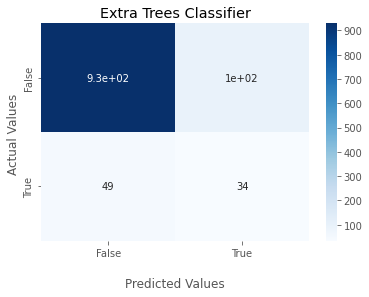

Accuracy score:  0.8929856115107914
Precision score:  0.2804878048780488
Recall score:  0.27710843373493976


In [123]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf.fit(x_res, y_res)

cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Extra Trees Classifier');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()


clf.score(X_test,y_test)
y_pred = clf.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Precision score: ", precision_score(y_test, y_pred))
print("Recall score: ", recall_score(y_test, y_pred))

In [124]:
from sklearn import svm
clf = svm.SVC()
clf.fit(x_res, y_res)

clf.score(X_test,y_test)
y_pred = clf.predict(X_test)
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Precision score: ", precision_score(y_test, y_pred))
print("Recall score: ", recall_score(y_test, y_pred))

Confusion matrix: 
 [[886 143]
 [ 57  26]]
Accuracy score:  0.8201438848920863
Precision score:  0.15384615384615385
Recall score:  0.3132530120481928


C:\Users\Clarence\Documents\School\1. DAI\AI_code\ai_env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


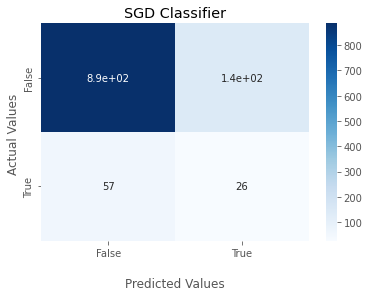

Accuracy score:  0.7517985611510791
Precision score:  0.12156862745098039
Recall score:  0.37349397590361444


In [125]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=10)
clf.fit(x_res, y_res)

cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('SGD Classifier');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

clf.score(X_test,y_test)
y_pred = clf.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Precision score: ", precision_score(y_test, y_pred))
print("Recall score: ", recall_score(y_test, y_pred))

In [126]:
x_res

,width,height,length,Heating Element Material_carbon,Heating Element Material_ceramic,Heating Element Material_metal,Heating Element Material_others,Heating Element Material_plastic,Heating Element Material_quartz,heating system_baseboard heater,...,heating system_oscillating heater,heating system_others,heating system_portable heater,Material_aluminium,Material_brass,Material_ceramic,Material_others,Material_plastic,Material_steel,Material_wood
0,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1076,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1077,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1078,13.885733,11.742737,17.800032,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [127]:
y_res.sum()

540

In [128]:
clf.coef_

array([[ -33.74069087, -628.61193724,  454.7548881 ,   -7.62776506,
           0.84752945,  112.72141707, -365.28519366,    0.        ,
         -11.01788287,  -98.31341639,  -13.56047123,  -39.83388423,
         -51.69929655,  -44.07153149,  -31.35858971,    0.        ,
        -143.23247733,  -87.29553352,  -48.30917874,  -25.42588355,
        -101.7035342 , -163.57318417,  -78.820239  , -105.94118146,
         -22.03576574]])

In [131]:
def topwords(doc): 
    en_stops = set(stopwords.words('english'))
    if type(doc[0]) == list: 
        doc = itertools.chain.from_iterable(doc)
    all_words = itertools.chain.from_iterable(map(lambda text: text.lower().split(), doc))
    all_words = filter(lambda word: word not in en_stops, all_words)
    counts = Counter(all_words)
    sorted_counts = sorted(counts, key=counts.get, reverse=True)
    return counts, sorted_counts

In [132]:
import itertools

good_ratings_features = df[df['Energy Star'].isin(good_ratings)]['Features']
good_ratings_features_no_null = good_ratings_features.dropna()
features = list(map(lambda text: list(map(lambda t: t.strip(), text.split(","))), good_ratings_features_no_null.tolist()))
features

features_list = list(itertools.chain.from_iterable(features))
topwords(features_list)[1]

['shut-off',
 'auto',
 'timer',
 'thermostat',
 'oscillation',
 'portable',
 'safety',
 'handle',
 'automatic',
 'protection',
 'shutoff',
 'tip-over',
 'control',
 'durable',
 'switch',
 'remote',
 'digital',
 'heater',
 'overheat',
 'heating',
 'display',
 'mini',
 'adjustable',
 'features',
 'exterior',
 'cool-touch',
 'multiple',
 'setting',
 'heat',
 'anti-freeze',
 'nonslip',
 'base',
 'indoor',
 'wheels',
 'see',
 'cool',
 'touch',
 'settings',
 'free',
 '3',
 'easy',
 'description',
 'fast',
 'electric',
 'operation',
 'vent',
 'degree',
 'cool-to-touch',
 'air',
 'noise',
 'fan',
 'low',
 '360',
 'dual',
 'storage',
 'thermal',
 'energy',
 'cool-to-the-touch',
 '2',
 'element',
 'plug',
 'warm',
 'tip',
 'carrying',
 'case',
 'power',
 'streamline',
 'size',
 'slots',
 'casters/wheels',
 'pipes',
 'saving',
 'silent',
 'never',
 'needs',
 'refilling',
 'convenient',
 'anti',
 'safe',
 'modes',
 'angle',
 'use',
 'item',
 'fuse',
 'ceramic',
 'fully',
 'assembled',
 'flame',
 '